# Data and main parameters

In [1]:
import math
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = 'datasets/'
# !git clone https://github.com/lqwic/deep_var.git
# %cd deep_var/

In [44]:
def load_data(file_path):
    return pd.read_csv(file_path, index_col='Date', parse_dates=True)

stocks = load_data(data_path + 'stocks.csv')
commodities = load_data(data_path + 'commodities.csv')
crypto = load_data(data_path + 'cryptos.csv')

window_size = 21
alpha = 99
train_size = 0.8
data = stocks

# Test Model

In [45]:
class DSVM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers, dropout_rate=0.1):
        super(DSVM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers
        self.encoder = nn.GRU(input_size=input_size + latent_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder_mu = nn.GRU(input_size=latent_size + input_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder_log_var = nn.GRU(input_size=latent_size + input_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Encoder
        #self.encoder = nn.GRU(input_size=input_size + latent_size + 1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.encoder_mu = nn.Linear(hidden_size, latent_size)
        self.encoder_log_var = nn.Linear(hidden_size, latent_size)
        
        # Decoder
        #self.decoder_mu = nn.GRU(input_size=latent_size + input_size + 1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        #self.decoder_log_var = nn.GRU(input_size=latent_size + input_size + 1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder_mu_out = nn.Linear(hidden_size, input_size)
        self.decoder_log_var_out = nn.Linear(hidden_size, input_size)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, hist_vol):
        batch_size, seq_length, input_size = x.size()
        h_enc = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        h_dec_mu = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        h_dec_log_var = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
    
        z_prev = torch.zeros(batch_size, self.latent_size).to(x.device)
        r_prev = torch.zeros(batch_size, self.input_size).to(x.device)
    
        z_list = []
        r_list = []
        mu_z_list = []
        log_var_z_list = []
    
        for t in range(seq_length):
            # Encoder
            # x[:, t, :]: (batch_size, input_size)
            # z_prev: (batch_size, latent_size)
            # hist_vol: (batch_size, input_size)
            encoder_input = torch.cat([x[:, t, :], z_prev, hist_vol], dim=-1)
            # encoder_input: (batch_size, input_size + latent_size + input_size)
            _, h_enc = self.encoder(encoder_input.unsqueeze(1), h_enc)
            # h_enc: (num_layers, batch_size, hidden_size)
            h_enc = self.dropout(h_enc)
            mu_z = self.encoder_mu(h_enc[-1])
            log_var_z = self.encoder_log_var(h_enc[-1])
            z = self.reparameterize(mu_z, log_var_z)
            # z: (batch_size, latent_size)
            z_list.append(z)
            mu_z_list.append(mu_z)
            log_var_z_list.append(log_var_z)
            z_prev = z

            # Decoder
            decoder_input = torch.cat([z, r_prev, hist_vol], dim=-1)
            # decoder_input: (batch_size, latent_size + input_size + input_size)
            _, h_dec_mu = self.decoder_mu(decoder_input.unsqueeze(1), h_dec_mu)
            _, h_dec_log_var = self.decoder_log_var(decoder_input.unsqueeze(1), h_dec_log_var)
            # h_dec_mu, h_dec_log_var: (num_layers, batch_size, hidden_size)
            h_dec_mu = self.dropout(h_dec_mu)
            h_dec_log_var = self.dropout(h_dec_log_var)
            mu_r = self.decoder_mu_out(h_dec_mu[-1])
            log_var_r = self.decoder_log_var_out(h_dec_log_var[-1])
            r = self.reparameterize(mu_r, log_var_r)
            # r: (batch_size, input_size)
            r_list.append(r)
            r_prev = x[:, t, :]
    
        z_list = torch.stack(z_list, dim=1)  # (batch_size, seq_length, latent_size)
        r_list = torch.stack(r_list, dim=1)  # (batch_size, seq_length, input_size)
        mu_z_list = torch.stack(mu_z_list, dim=1)  # (batch_size, seq_length, latent_size)
        log_var_z_list = torch.stack(log_var_z_list, dim=1)  # (batch_size, seq_length, latent_size)
    
        kld_loss = self.kld_loss(mu_z_list, log_var_z_list)
        recon_loss, recon_loss_vol = self.reconstruction_loss(r_list, x)
        return kld_loss, recon_loss, recon_loss_vol, z_list, r_list, mu_z_list, log_var_z_list


    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def kld_loss(self, mu, log_var):
        kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return kld

    def reconstruction_loss(self, r, x):
        recon_loss_mean = F.mse_loss(r[:, :, :-1], x[:, :, :-1], reduction='sum')
        recon_loss_vol = F.mse_loss(r[:, :, -1], x[:, :, -1], reduction='sum')
        recon_loss = recon_loss_mean + 2 * recon_loss_vol  # Weighted loss
        return recon_loss, recon_loss_vol

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DSVM(13, 16, 10, 1).to(device)

r_prev = torch.rand(1, 21, 13).to(device)
hist_vol = torch.rand(1, 13).to(device)  # Generate random historical volatility estimates

kld_loss, recon_loss, recon_loss_vol, z_list, r_list, mu_z_list, log_var_z_list = model(r_prev, hist_vol)

print("Reconstructed output:")
print(r_list[0][0])
print("Original input:")
print(r_prev[0][0])

Reconstructed output:
tensor([ 0.3910,  1.7730, -0.4267,  0.6837, -3.3154,  1.0101, -0.8070,  1.0055,
         0.4046, -1.1256, -1.5630,  0.2146, -1.0260],
       grad_fn=<SelectBackward0>)
Original input:
tensor([0.4431, 0.0228, 0.2457, 0.7191, 0.4971, 0.2614, 0.9900, 0.8466, 0.8271,
        0.4323, 0.0594, 0.0303, 0.6473])


# Model

In [47]:
class DSVM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers, dropout_rate=0.1):
        super(DSVM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = num_layers
        self.encoder = nn.GRU(input_size=input_size + latent_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder_mu = nn.GRU(input_size=latent_size + input_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder_log_var = nn.GRU(input_size=latent_size + input_size + input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Encoder
        #self.encoder = nn.GRU(input_size=input_size + latent_size + 1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.encoder_mu = nn.Linear(hidden_size, latent_size)
        self.encoder_log_var = nn.Linear(hidden_size, latent_size)
        
        # Decoder
        #self.decoder_mu = nn.GRU(input_size=latent_size + input_size + 1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        #self.decoder_log_var = nn.GRU(input_size=latent_size + input_size + 1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder_mu_out = nn.Linear(hidden_size, input_size)
        self.decoder_log_var_out = nn.Linear(hidden_size, input_size)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, hist_vol):
        batch_size, seq_length, input_size = x.size()
        h_enc = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        h_dec_mu = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        h_dec_log_var = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
    
        z_prev = torch.zeros(batch_size, self.latent_size).to(x.device)
        r_prev = torch.zeros(batch_size, self.input_size).to(x.device)
    
        z_list = []
        r_list = []
        mu_z_list = []
        log_var_z_list = []
    
        for t in range(seq_length):
            # Encoder
            # x[:, t, :]: (batch_size, input_size)
            # z_prev: (batch_size, latent_size)
            # hist_vol: (batch_size, input_size)
            encoder_input = torch.cat([x[:, t, :], z_prev, hist_vol], dim=-1)
            # encoder_input: (batch_size, input_size + latent_size + input_size)
            _, h_enc = self.encoder(encoder_input.unsqueeze(1), h_enc)
            # h_enc: (num_layers, batch_size, hidden_size)
            h_enc = self.dropout(h_enc)
            mu_z = self.encoder_mu(h_enc[-1])
            log_var_z = self.encoder_log_var(h_enc[-1])
            z = self.reparameterize(mu_z, log_var_z)
            # z: (batch_size, latent_size)
            z_list.append(z)
            mu_z_list.append(mu_z)
            log_var_z_list.append(log_var_z)
            z_prev = z

            # Decoder
            decoder_input = torch.cat([z, r_prev, hist_vol], dim=-1)
            # decoder_input: (batch_size, latent_size + input_size + input_size)
            _, h_dec_mu = self.decoder_mu(decoder_input.unsqueeze(1), h_dec_mu)
            _, h_dec_log_var = self.decoder_log_var(decoder_input.unsqueeze(1), h_dec_log_var)
            # h_dec_mu, h_dec_log_var: (num_layers, batch_size, hidden_size)
            h_dec_mu = self.dropout(h_dec_mu)
            h_dec_log_var = self.dropout(h_dec_log_var)
            mu_r = self.decoder_mu_out(h_dec_mu[-1])
            log_var_r = self.decoder_log_var_out(h_dec_log_var[-1])
            r = self.reparameterize(mu_r, log_var_r)
            # r: (batch_size, input_size)
            r_list.append(r)
            r_prev = x[:, t, :]
    
        z_list = torch.stack(z_list, dim=1)  # (batch_size, seq_length, latent_size)
        r_list = torch.stack(r_list, dim=1)  # (batch_size, seq_length, input_size)
        mu_z_list = torch.stack(mu_z_list, dim=1)  # (batch_size, seq_length, latent_size)
        log_var_z_list = torch.stack(log_var_z_list, dim=1)  # (batch_size, seq_length, latent_size)
    
        kld_loss = self.kld_loss(mu_z_list, log_var_z_list)
        recon_loss, recon_loss_vol = self.reconstruction_loss(r_list, x)
        return kld_loss, recon_loss, recon_loss_vol, z_list, r_list, mu_z_list, log_var_z_list


    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def kld_loss(self, mu, log_var):
        kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return kld

    def reconstruction_loss(self, r, x):
        recon_loss_mean = F.mse_loss(r[:, :, :-1], x[:, :, :-1], reduction='sum')
        recon_loss_vol = F.mse_loss(r[:, :, -1], x[:, :, -1], reduction='sum')
        recon_loss = recon_loss_mean + 2 * recon_loss_vol  # Weighted loss
        return recon_loss, recon_loss_vol

# Training

In [48]:
from torch.utils.data import DataLoader, TensorDataset

def preprocess_data(data, seq_length=21, train_ratio=0.66):
    data = data.values
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean) / data_std

    # Calculate historical volatility (e.g., using rolling standard deviation)
    hist_vol = pd.DataFrame(data).rolling(window=seq_length).std().values

    sequences = []
    hist_vols = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(torch.tensor(data[i:i+seq_length], dtype=torch.float32))
        hist_vols.append(torch.tensor(hist_vol[i+seq_length-1], dtype=torch.float32))

    train_size = int(train_ratio * len(sequences))
    train_sequences = sequences[:train_size]
    train_hist_vols = hist_vols[:train_size]
    test_sequences = sequences[train_size - seq_length:]
    test_hist_vols = hist_vols[train_size - seq_length:]

    train_dataset = TensorDataset(torch.stack(train_sequences), torch.stack(train_hist_vols))
    test_dataset = TensorDataset(torch.stack(test_sequences), torch.stack(test_hist_vols))

    return train_dataset, test_dataset, data_mean, data_std

In [49]:
seq_length = 21
batch_size = 256
train_dataset, test_dataset, data_mean, data_std = preprocess_data(data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [50]:
for batch in train_loader:
    seq_batch, vol_batch = batch
    print(seq_batch.shape, vol_batch.shape)
    break

torch.Size([256, 21, 369]) torch.Size([256, 369])


In [51]:
def train(model, train_loader, optimizer, device=torch.device('cpu')):
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_recon_loss_vol = 0
    train_kl_loss = 0
    
    for batch in train_loader:
        seq_batch, vol_batch = batch
        seq_batch = seq_batch.to(device)
        vol_batch = vol_batch.to(device)
        
        optimizer.zero_grad()
        kld_loss, recon_loss, recon_loss_vol, _, _, _, _ = model(seq_batch, vol_batch)
        loss = kld_loss + recon_loss
        loss.backward()
        
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_recon_loss_vol += recon_loss_vol.item()
        train_kl_loss += kld_loss.item()
        
        optimizer.step()
    
    train_loss /= len(train_loader.dataset)
    train_recon_loss /= len(train_loader.dataset)
    train_recon_loss_vol /= len(train_loader.dataset)
    train_kl_loss /= len(train_loader.dataset)
    
    return train_loss, train_recon_loss, train_recon_loss_vol, train_kl_loss

def test(model, test_loader, device=torch.device('cpu')):
    model.eval()
    test_loss = 0
    test_recon_loss = 0
    test_recon_loss_vol = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for batch in test_loader:
            seq_batch, vol_batch = batch
            seq_batch = seq_batch.to(device)
            vol_batch = vol_batch.to(device)
            
            kld_loss, recon_loss, recon_loss_vol, _, _, _, _ = model(seq_batch, vol_batch)
            loss = kld_loss + recon_loss
            
            test_loss += loss.item()
            test_recon_loss += recon_loss.item()
            test_recon_loss_vol += recon_loss_vol.item()
            test_kl_loss += kld_loss.item()
    
    test_loss /= len(test_loader.dataset)
    test_recon_loss /= len(test_loader.dataset)
    test_recon_loss_vol /= len(test_loader.dataset)
    test_kl_loss /= len(test_loader.dataset)
    
    return test_loss, test_recon_loss, test_recon_loss_vol, test_kl_loss

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 9648.1723, Train Recon Loss: 9645.3024, Train Recon Loss Vol: 25.5586, Train KL Loss: 2.8700, Test Loss: 8142.4290, Test Recon Loss: 8142.3207, Test Recon Loss Vol: 19.2298, Test KL Loss: 0.1083
Epoch [20/1000], Train Loss: 8760.9030, Train Recon Loss: 8758.9967, Train Recon Loss Vol: 23.9481, Train KL Loss: 1.9063, Test Loss: 7337.0059, Test Recon Loss: 7336.9640, Test Recon Loss Vol: 17.9261, Test KL Loss: 0.0418
Epoch [30/1000], Train Loss: 8507.1917, Train Recon Loss: 8506.0112, Train Recon Loss Vol: 23.5706, Train KL Loss: 1.1806, Test Loss: 7104.2068, Test Recon Loss: 7104.1854, Test Recon Loss Vol: 17.6000, Test KL Loss: 0.0214
Epoch [40/1000], Train Loss: 8399.7716, Train Recon Loss: 8399.0858, Train Recon Loss Vol: 23.3600, Train KL Loss: 0.6857, Test Loss: 7009.2243, Test Recon Loss: 7009.2104, Test Recon Loss Vol: 17.4436, Test KL Loss: 0.0137
Epoch [50/1000], Train Loss: 8341.4405, Train Recon Loss: 8341.0510, Train Recon Loss Vol: 23.3125, Trai

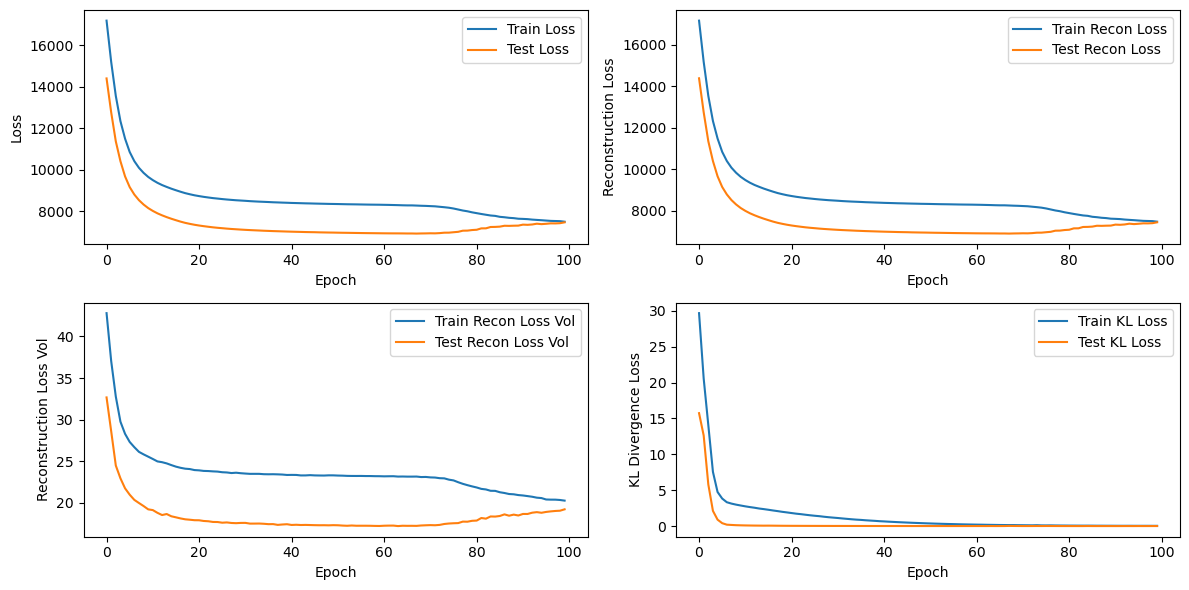

Epoch [110/1000], Train Loss: 7385.3803, Train Recon Loss: 7385.3537, Train Recon Loss Vol: 19.8509, Train KL Loss: 0.0265, Test Loss: 7595.3407, Test Recon Loss: 7595.3371, Test Recon Loss Vol: 19.7382, Test KL Loss: 0.0037


In [ ]:
import os

input_dim = data.shape[1]
latent_dim = 10
hidden_dim = 16
num_layers = 1
seq_length = 21
batch_size = 256
learning_rate = 0.001
epochs = 1000
save_interval = 100
plot_interval = 100
decay_rate = 0.96
decay_steps = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DSVM(input_dim, hidden_dim, latent_dim, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

save_dir = 'gaussHVVAE_checkpoints'
os.makedirs(save_dir, exist_ok=True)

model.train()

train_losses = []
test_losses = []
train_recon_losses = []
test_recon_losses = []
train_recon_losses_vol = []
test_recon_losses_vol = []
train_kl_losses = []
test_kl_losses = []

# torch.autograd.set_detect_anomaly(True)

for epoch in trange(1, epochs+1):
    train_loss, train_recon_loss, train_recon_loss_vol, train_kl_loss = train(model, train_loader, optimizer, device)
    test_loss, test_recon_loss, test_recon_loss_vol, test_kl_loss = test(model, test_loader, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_recon_losses_vol.append(train_recon_loss_vol)
    test_recon_losses_vol.append(test_recon_loss_vol)
    train_kl_losses.append(train_kl_loss)
    test_kl_losses.append(test_kl_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Recon Loss: {train_recon_loss:.4f}, "
              f"Train Recon Loss Vol: {train_recon_loss_vol:.4f}, "
              f"Train KL Loss: {train_kl_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Recon Loss: {test_recon_loss:.4f}, "
              f"Test Recon Loss Vol: {test_recon_loss_vol:.4f}, "
              f"Test KL Loss: {test_kl_loss:.4f}")
    
    if epoch % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
    
    if epoch % plot_interval == 0:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(test_recon_losses, label='Test Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()
        
        plt.subplot(2, 2, 3)
        plt.plot(train_recon_losses_vol, label='Train Recon Loss Vol')
        plt.plot(test_recon_losses_vol, label='Test Recon Loss Vol')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss Vol')
        plt.legend()
        
        plt.subplot(2, 2, 4)
        plt.plot(train_kl_losses, label='Train KL Loss')
        plt.plot(test_kl_losses, label='Test KL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('KL Divergence Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    lr = learning_rate * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Further training

# Plotting

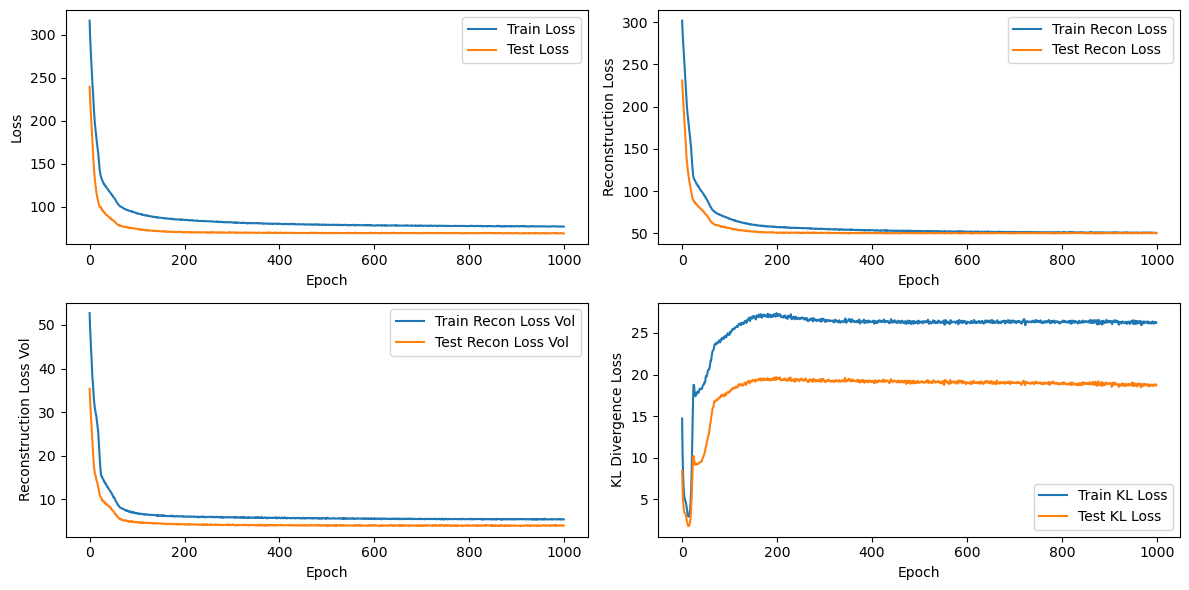

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_recon_losses, label='Train Recon Loss')
plt.plot(test_recon_losses, label='Test Recon Loss')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_recon_losses_vol, label='Train Recon Loss Vol')
plt.plot(test_recon_losses_vol, label='Test Recon Loss Vol')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss Vol')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_kl_losses, label='Train KL Loss')
plt.plot(test_kl_losses, label='Test KL Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence Loss')
plt.legend()

plt.tight_layout()
plt.savefig(f"GaussHVVAE_training_plot.png")
plt.show()

  0%|          | 0/1001 [00:00<?, ?it/s]

Epoch [1000/2000], Train Loss: 180.4886, Train Recon Loss: 151.6221, Train KL Loss: 28.8666, Test Loss: 73.9488, Test Recon Loss: 50.1582, Test KL Loss: 23.7906


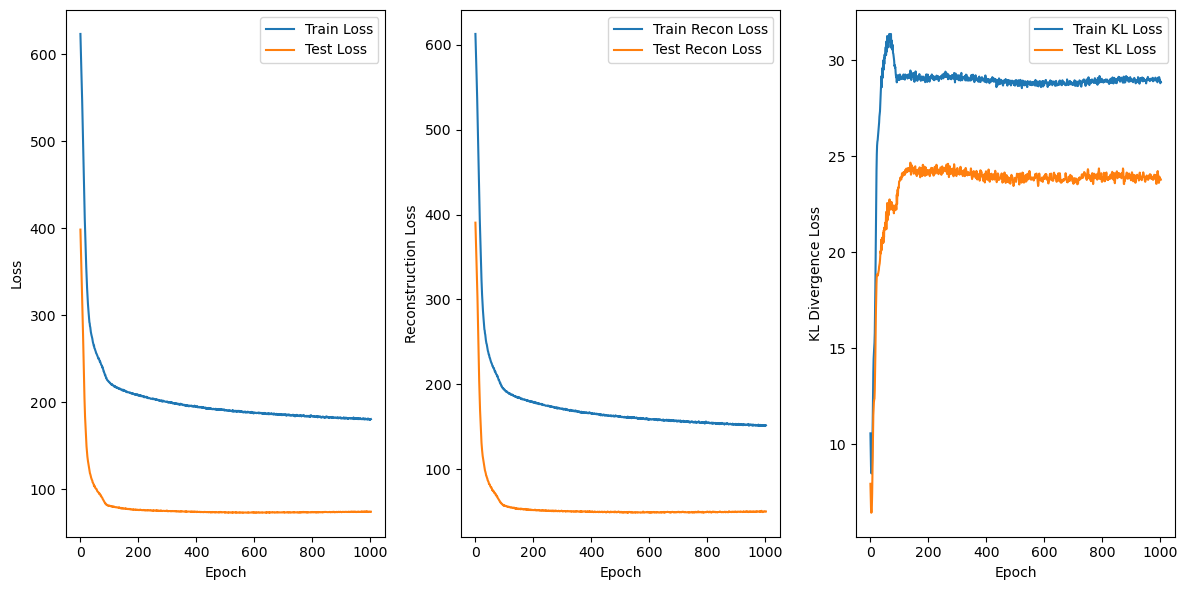

Epoch [1010/2000], Train Loss: 180.5571, Train Recon Loss: 151.7100, Train KL Loss: 28.8472, Test Loss: 74.1220, Test Recon Loss: 50.3348, Test KL Loss: 23.7871
Epoch [1020/2000], Train Loss: 179.9751, Train Recon Loss: 151.1420, Train KL Loss: 28.8331, Test Loss: 73.8383, Test Recon Loss: 50.0481, Test KL Loss: 23.7902
Epoch [1030/2000], Train Loss: 181.6424, Train Recon Loss: 152.7823, Train KL Loss: 28.8602, Test Loss: 73.9215, Test Recon Loss: 50.1332, Test KL Loss: 23.7883
Epoch [1040/2000], Train Loss: 180.2108, Train Recon Loss: 151.3978, Train KL Loss: 28.8129, Test Loss: 73.9677, Test Recon Loss: 50.1804, Test KL Loss: 23.7873
Epoch [1050/2000], Train Loss: 179.9364, Train Recon Loss: 151.0555, Train KL Loss: 28.8809, Test Loss: 73.9303, Test Recon Loss: 50.1402, Test KL Loss: 23.7902
Epoch [1060/2000], Train Loss: 179.7245, Train Recon Loss: 150.8427, Train KL Loss: 28.8818, Test Loss: 73.8513, Test Recon Loss: 50.0612, Test KL Loss: 23.7901
Epoch [1070/2000], Train Loss: 180

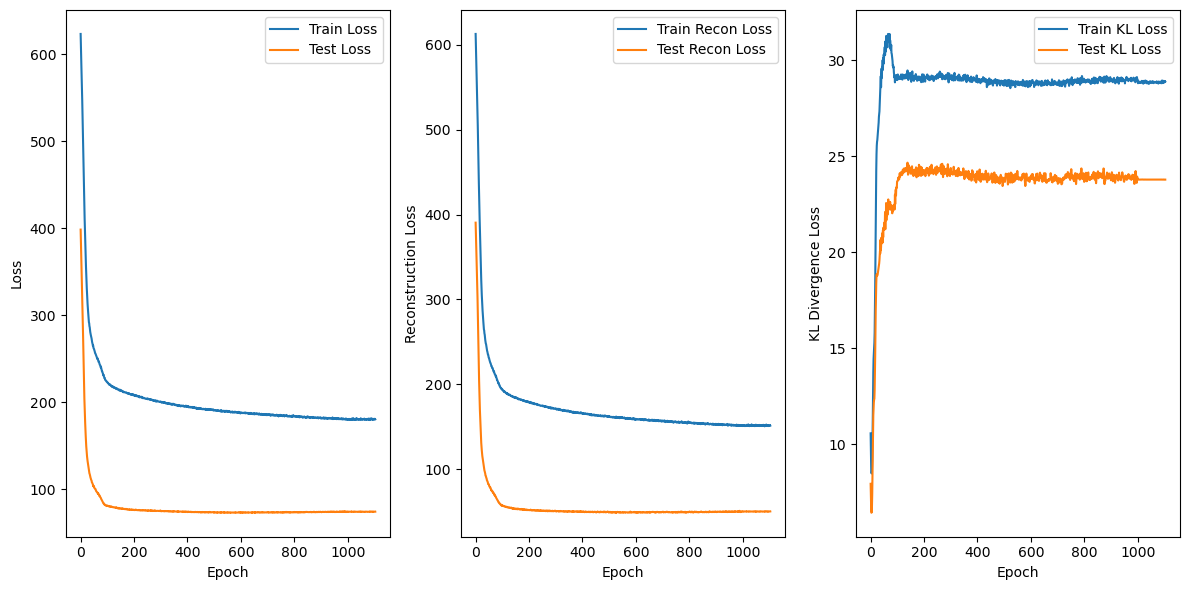

Epoch [1110/2000], Train Loss: 180.3893, Train Recon Loss: 151.5363, Train KL Loss: 28.8530, Test Loss: 73.7850, Test Recon Loss: 49.9934, Test KL Loss: 23.7917
Epoch [1120/2000], Train Loss: 180.1802, Train Recon Loss: 151.3626, Train KL Loss: 28.8176, Test Loss: 73.8885, Test Recon Loss: 50.0969, Test KL Loss: 23.7916
Epoch [1130/2000], Train Loss: 180.4651, Train Recon Loss: 151.5222, Train KL Loss: 28.9429, Test Loss: 73.8610, Test Recon Loss: 50.0725, Test KL Loss: 23.7885
Epoch [1140/2000], Train Loss: 180.5839, Train Recon Loss: 151.7632, Train KL Loss: 28.8207, Test Loss: 73.7585, Test Recon Loss: 49.9683, Test KL Loss: 23.7903
Epoch [1150/2000], Train Loss: 180.6879, Train Recon Loss: 151.7882, Train KL Loss: 28.8997, Test Loss: 74.0779, Test Recon Loss: 50.2882, Test KL Loss: 23.7897
Epoch [1160/2000], Train Loss: 180.4344, Train Recon Loss: 151.5401, Train KL Loss: 28.8943, Test Loss: 73.9548, Test Recon Loss: 50.1669, Test KL Loss: 23.7879
Epoch [1170/2000], Train Loss: 180

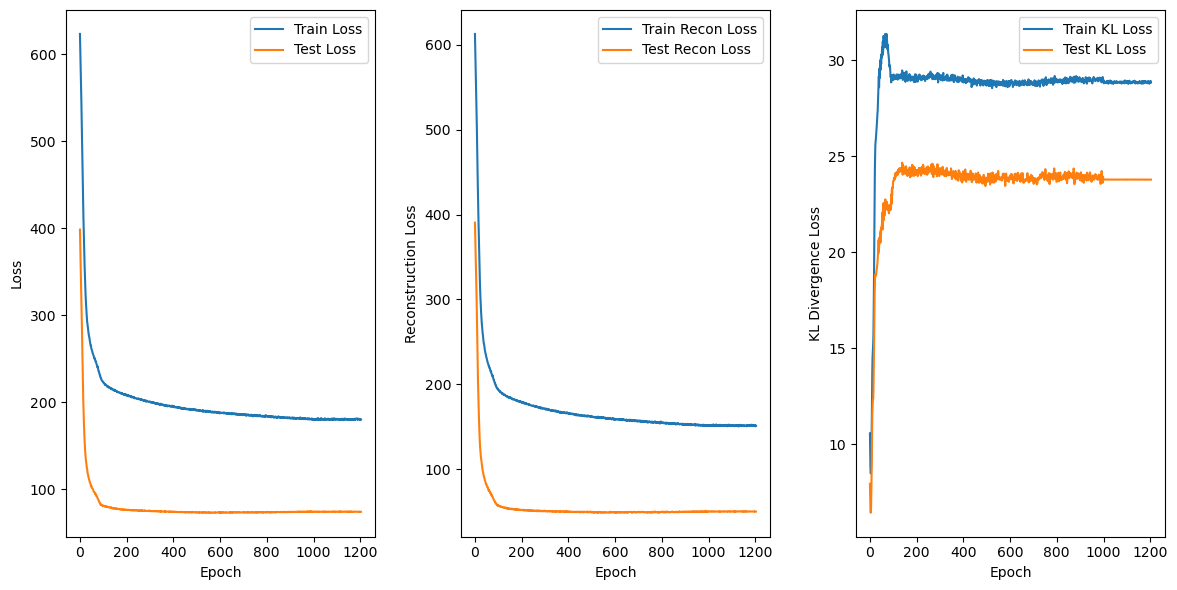

Epoch [1210/2000], Train Loss: 180.9347, Train Recon Loss: 152.0493, Train KL Loss: 28.8854, Test Loss: 73.9083, Test Recon Loss: 50.1169, Test KL Loss: 23.7913
Epoch [1220/2000], Train Loss: 179.5177, Train Recon Loss: 150.6257, Train KL Loss: 28.8920, Test Loss: 73.8434, Test Recon Loss: 50.0525, Test KL Loss: 23.7909
Epoch [1230/2000], Train Loss: 179.9587, Train Recon Loss: 151.0718, Train KL Loss: 28.8869, Test Loss: 73.9142, Test Recon Loss: 50.1225, Test KL Loss: 23.7918
Epoch [1240/2000], Train Loss: 180.1222, Train Recon Loss: 151.2532, Train KL Loss: 28.8690, Test Loss: 73.9961, Test Recon Loss: 50.2055, Test KL Loss: 23.7907
Epoch [1250/2000], Train Loss: 180.4203, Train Recon Loss: 151.5211, Train KL Loss: 28.8992, Test Loss: 73.9058, Test Recon Loss: 50.1173, Test KL Loss: 23.7885
Epoch [1260/2000], Train Loss: 179.7586, Train Recon Loss: 150.9314, Train KL Loss: 28.8272, Test Loss: 73.8938, Test Recon Loss: 50.1057, Test KL Loss: 23.7881
Epoch [1270/2000], Train Loss: 180

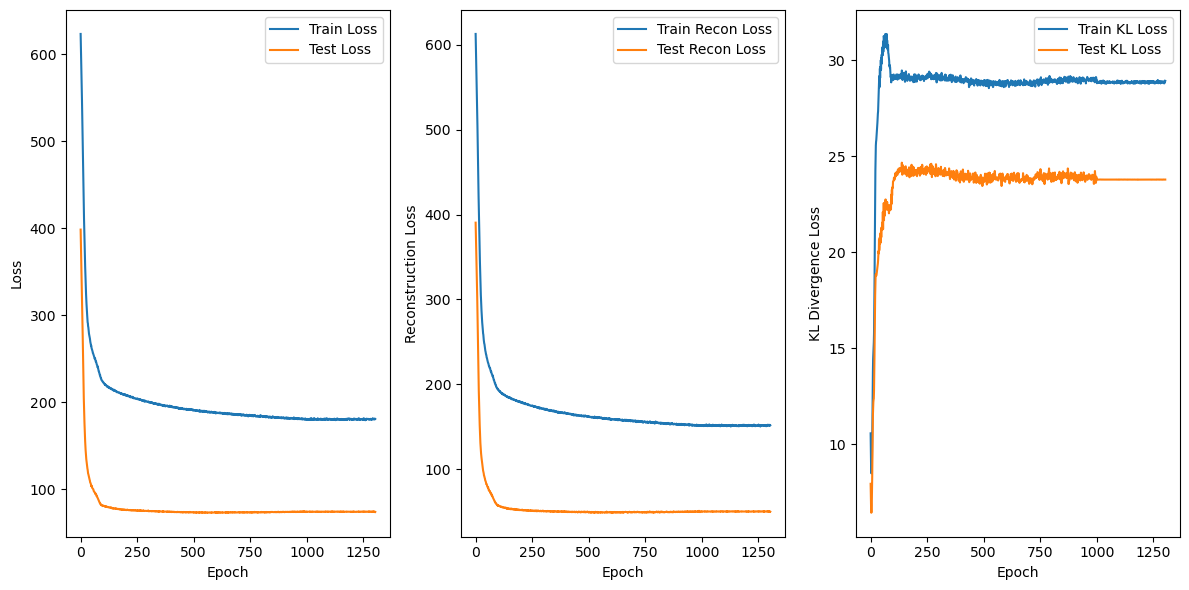

KeyboardInterrupt: 

In [69]:
end_epoch = 1000
model = DSVM(input_dim, hidden_dim, latent_dim, num_layers).to(device)
model.load_state_dict(torch.load('model_checkpoints/model_epoch_1000.pth'))

epochs = 2000

model.train()
for epoch in trange(end_epoch, epochs+1):
    train_loss, train_recon_loss, train_kl_loss = train(model, train_loader, optimizer, device)
    test_loss, test_recon_loss, test_kl_loss = test(model, test_loader, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_kl_losses.append(train_kl_loss)
    test_kl_losses.append(test_kl_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Recon Loss: {train_recon_loss:.4f}, "
              f"Train KL Loss: {train_kl_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Recon Loss: {test_recon_loss:.4f}, "
              f"Test KL Loss: {test_kl_loss:.4f}")
    
    if epoch % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
    
    if epoch % plot_interval == 0:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 3, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(test_recon_losses, label='Test Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(train_kl_losses, label='Train KL Loss')
        plt.plot(test_kl_losses, label='Test KL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('KL Divergence Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    lr = learning_rate * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Final model

In [78]:
model = DSVM(input_dim, hidden_dim, latent_dim, num_layers).to(device)
model.load_state_dict(torch.load('model_checkpoints/model_epoch_1000.pth'))

<All keys matched successfully>

# Testing randomness

In [34]:
model.eval()
historical_returns, hist_vol = next(iter(test_loader))
historical_returns = historical_returns.to(device)
hist_vol = hist_vol.to(device)

with torch.no_grad():
    kld_loss, recon_loss, recon_loss_vol, z_list, r_list, mu_z_list, log_var_z_list = model(historical_returns, hist_vol)

print(f"Input sequence (historical_returns) of {historical_returns.shape}:")
print(historical_returns[0][0])
print(f"Generated r_list of {r_list.shape}:")
print(r_list[0][0])

Input sequence (historical_returns) of torch.Size([256, 21, 5]):
tensor([-0.1403,  0.0317, -0.0379, -0.3395,  0.1052])
Generated r_list of torch.Size([256, 21, 5]):
tensor([-0.0617, -0.3200, -0.0656,  0.0458, -0.2994])


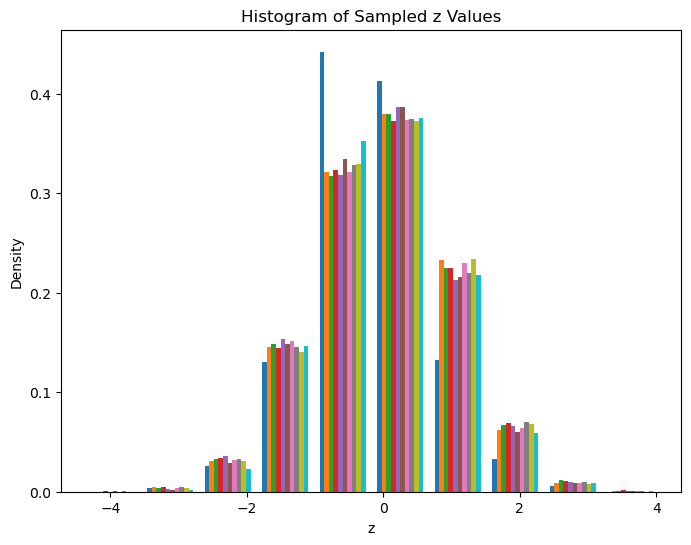

In [35]:
z_samples = torch.zeros_like(mu_z_list)
for t in range(mu_z_list.size(1)):
    z_samples[:, t, :] = model.reparameterize(mu_z_list[:, t, :], log_var_z_list[:, t, :])

z_samples = z_samples.view(-1, model.latent_size).cpu().numpy()

plt.figure(figsize=(8, 6))
plt.hist(z_samples, density=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.title('Histogram of Sampled z Values')
plt.show()

# VaR Forecasting

In [36]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
model.eval()

DSVM(
  (encoder): GRU(20, 16, batch_first=True)
  (decoder_mu): GRU(20, 16, batch_first=True)
  (decoder_log_var): GRU(20, 16, batch_first=True)
  (encoder_mu): Linear(in_features=16, out_features=10, bias=True)
  (encoder_log_var): Linear(in_features=16, out_features=10, bias=True)
  (decoder_mu_out): Linear(in_features=16, out_features=5, bias=True)
  (decoder_log_var_out): Linear(in_features=16, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

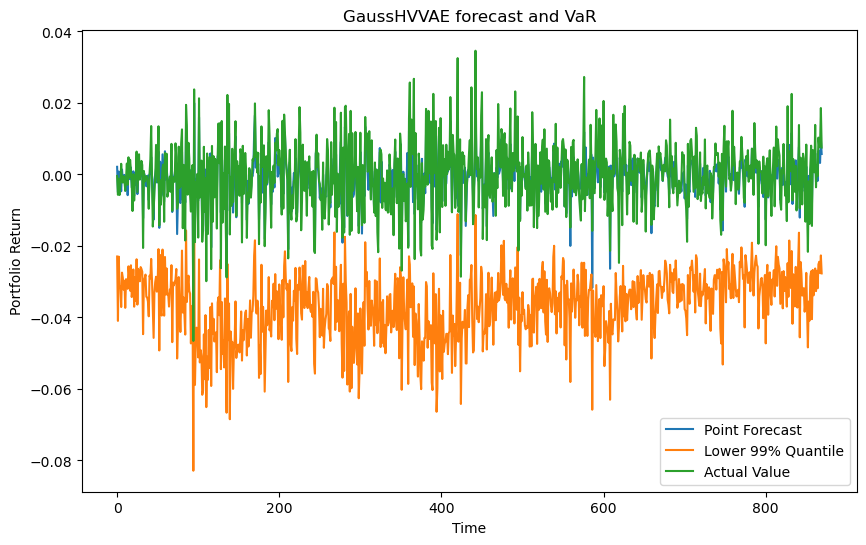

In [38]:
def one_step_ahead_forecast(model, historical_returns, hist_vol, portfolio_weights, data_mean, data_std, num_samples=1000, device=torch.device('cpu')):
    model.eval()
    with torch.no_grad():
        batch_size, seq_length, _ = historical_returns.shape
        h_enc = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        h_dec_mu = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        h_dec_log_var = torch.zeros(model.num_layers, batch_size, model.hidden_size).to(device)
        z_prev = torch.zeros(batch_size, model.latent_size).to(device)

        for t in range(seq_length):
            encoder_input = torch.cat([historical_returns[:, t, :], z_prev, hist_vol], dim=-1)
            _, h_enc = model.encoder(encoder_input.unsqueeze(1), h_enc)
            mu_z = model.encoder_mu(h_enc[-1])
            log_var_z = model.encoder_log_var(h_enc[-1])
            z_prev = model.reparameterize(mu_z, log_var_z)

        z_samples = []
        for _ in range(num_samples):
            eps = torch.randn_like(z_prev)
            z_sample = model.reparameterize(mu_z, eps)
            z_samples.append(z_sample)
        z_samples = torch.stack(z_samples)

        forecasts = []
        for z_sample in z_samples:
            decoder_input = torch.cat([z_sample, historical_returns[:, -1, :], hist_vol], dim=-1)
            _, h_dec_mu = model.decoder_mu(decoder_input.unsqueeze(1), h_dec_mu)
            _, h_dec_log_var = model.decoder_log_var(decoder_input.unsqueeze(1), h_dec_log_var)
            mu_r = model.decoder_mu_out(h_dec_mu[-1])
            forecast = model.reparameterize(mu_r, torch.zeros_like(mu_r))
            forecasts.append(forecast.squeeze())

        forecasts = torch.stack(forecasts)
        forecasts = forecasts * data_std + data_mean  # Renormalize the forecasts and move to device
        portfolio_forecasts = torch.matmul(forecasts.double(), portfolio_weights.double())  # Convert both to double
        point_forecast = portfolio_forecasts.mean().item()
        lower_quantile = torch.quantile(portfolio_forecasts, 0.01).item()
        return point_forecast, lower_quantile

def generate_forecasts(model, test_loader, portfolio_weights, data_mean, data_std, device=torch.device('cpu')):
    model.eval()
    point_forecasts = []
    lower_quantiles = []
    actual_values = []

    with torch.no_grad():
        for i, (historical_returns, hist_vol) in enumerate(test_loader):
            historical_returns = historical_returns.to(device)
            hist_vol = hist_vol.to(device)
            point_forecast, lower_quantile = one_step_ahead_forecast(model, historical_returns, hist_vol, portfolio_weights, data_mean, data_std, device=device)
            point_forecasts.append(point_forecast)
            lower_quantiles.append(lower_quantile)
            actual_value = torch.matmul(test_dataset.tensors[0][i][-1] * data_std + data_mean, portfolio_weights.double()).item()
            actual_values.append(actual_value)

    return point_forecasts, lower_quantiles, actual_values

portfolio_weights = np.loadtxt('weights_commodities99.csv', delimiter=',')
portfolio_weights = torch.tensor(portfolio_weights, dtype=torch.float32, device=device)

point_forecasts, lower_quantiles, actual_values = generate_forecasts(model, test_loader, portfolio_weights, data_mean, data_std, device=device)

plt.figure(figsize=(10, 6))
plt.plot(point_forecasts, label='Point Forecast')
plt.plot(lower_quantiles, label='Lower 99% Quantile')
plt.plot(actual_values, label='Actual Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Return')
plt.legend()
plt.title("GaussHVVAE forecast and VaR")
plt.savefig(f"GaussHVVAE_forecast_plot.png")
plt.show()

870 870


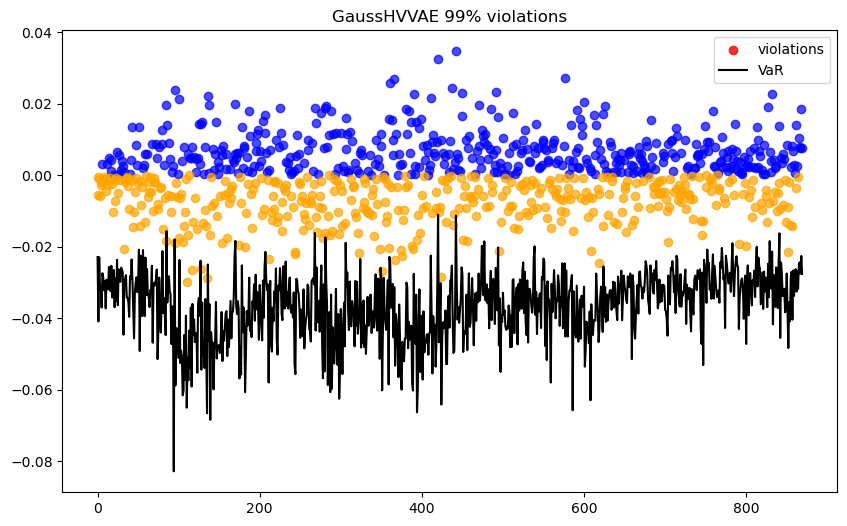

In [39]:
import matplotlib.pyplot as plt

# Assuming act_v and lower_quantiles are lists of the same length
portfolio = actual_values
var_values = lower_quantiles
print(len(portfolio), len(var_values))

# Create a DataFrame to store the data
var_df = pd.DataFrame({'Returns': portfolio, 'VaR': var_values}, index=range(0, len(actual_values)))

# Separate positive and negative returns
pos = var_df[var_df['Returns'] >= 0]
neg = var_df[var_df['Returns'] < 0]

# Calculate violations
var_df['Violation'] = (var_df['Returns'] < var_df['VaR'])
breakdowns = var_df[var_df['Violation'] == 1]

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(pos.index, pos['Returns'], c='blue', alpha=0.7)
plt.scatter(neg.index, neg['Returns'], c='orange', alpha=0.7)
plt.scatter(breakdowns.index, breakdowns['Returns'], c='red', alpha=0.8, label='violations')
plt.plot(var_df.index, var_df['VaR'], label='VaR', c='black')

plt.legend()
plt.title("GaussHVVAE 99% violations")
plt.savefig(f"GaussHVVAE_breakdown_plot.png")
plt.show()

In [40]:
var_df.to_csv('GaussHVVAE_predictions.csv', index=False)

In [41]:
import numpy as np
from scipy.stats import chi2, norm
import pandas as pd

def pof_test(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Kupiec's Proportion of Failure Test (POF). Tests that the number of exceptions
    corresponds to the VaR confidence level.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: VaR confidence level. Default is 0.99.

    Returns:
        p-value of POF test.
    """
    exception = target < var
    t = len(target)
    m = exception.sum()
    p = 1 - alpha
    lr_pof = -2 * (m * np.log(p / (m / t)) + (t - m) * np.log((1 - p) / (1 - m / t)))
    pvalue = 1 - chi2.cdf(lr_pof, df=1)
    return pvalue

def berkowitz_test(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Berkowitz Test assesses the calibration of VaR forecasts. It tests whether the realized
    losses are consistent with the predicted VaR level.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: VaR confidence level. Default is 0.99.

    Returns:
        p-value of the Berkowitz test.
    """
    z = (target - var.mean()) / var.std()
    lr_berkowitz = -2 * (np.log(norm.cdf(z)).sum() - np.log(alpha) * (target < var).sum() - np.log(1 - alpha) * (target >= var).sum())
    pvalue = 1 - chi2.cdf(lr_berkowitz, df=1)
    return pvalue

def quantile_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Quantile loss also known as Pinball loss. Measures the discrepancy between
    true values and a corresponding 1-alpha quantile.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: VaR confidence level. Default is 0.99.

    Returns:
        The average value of the quantile loss function.
    """
    return np.where(target < var, alpha * (var - target), (1 - alpha) * (target - var)).mean()

def quadratic_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99, a: float = 1.0) -> float:
    """
    Quadratic Loss measures the squared difference between the predicted VaR and returns,
    penalizing negative returns with weight (return - VaR)^2 and negative VaRs with
    weight -a * VaR.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: Weight parameter for return - VaR. Default is 0.99.
        a: Weight parameter for negative VaRs. Default is 1.

    Returns:
        Quadratic Loss value.
    """
    return np.where(target < var, (target - var)**2, -a * var).mean()

def smooth_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99, d: float = 25.0) -> float:
    """
    Smooth Loss penalizes observations for which return - VaR < 0 more heavily with weight (1-alpha).

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: Weight parameter. Default is 0.99.
        d: Parameter Default is 25.

    Returns:
        Smooth Loss value.
    """
    return ((alpha - (1 + np.exp(d * (target - var)))**(-1)) * (target - var)).mean()

def tick_loss(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> float:
    """
    Tick Loss penalizes exceedances with weight alpha and non-exceedances with weight 1 - alpha.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.
        alpha: Weight parameter. Default is 0.99.

    Returns:
        Tick Loss value.
    """
    return ((alpha - (target < var).astype(float)) * (target - var)).mean()

def avg_exceedances(var: np.ndarray, target: np.ndarray) -> float:
    """
    Calculate the average number of exceedances.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.

    Returns:
        Average number of exceedances.
    """
    exceedances = (target < var).sum()
    return exceedances / len(target)

def regulatory_loss(var: np.ndarray, target: np.ndarray) -> float:
    """
    Regulatory Loss Function penalizes exceedances with squared difference and non-exceedances with 0.

    Parameters:
        var: Predicted VaRs.
        target: Corresponding returns.

    Returns:
        Regulatory Loss value.
    """
    return np.where(target < var, (var - target)**2, 0).mean()

def metrics(var: np.ndarray, target: np.ndarray, alpha: float = 0.99) -> dict:
    metrics_dict = {}

    metrics_dict['POF Test p-value'] = pof_test(var, target, alpha)
    metrics_dict['Berkowitz Test p-value'] = berkowitz_test(var, target, alpha)
    metrics_dict['Quantile Loss'] = quantile_loss(var, target, alpha)
    metrics_dict['Quadratic Loss'] = quadratic_loss(var, target, alpha)
    metrics_dict['Smooth Loss'] = smooth_loss(var, target, alpha)
    metrics_dict['Tick Loss'] = tick_loss(var, target, alpha)
    metrics_dict['Average Exceedances'] = avg_exceedances(var, target)
    metrics_dict['Regulatory Loss'] = regulatory_loss(var, target)

    return metrics_dict

def calculate_metrics_table(target: pd.Series, predictions_dict: dict, alpha: float = 0.99) -> pd.DataFrame:
    metrics_list = [
        'POF Test p-value',
        'Berkowitz Test p-value',
        'Quantile Loss',
        'Quadratic Loss',
        'Smooth Loss',
        'Tick Loss',
        'Average Exceedances',
        'Regulatory Loss'
    ]
    metrics_table = pd.DataFrame(index=metrics_list)

    for model, predictions in predictions_dict.items():
        metrics_dict = metrics(predictions, target, alpha)
        metrics_table[model] = metrics_dict.values()

    return metrics_table

In [42]:
metr = metrics(var_df['VaR'], var_df['Returns'])
pd.DataFrame.from_dict(metr, orient='index', columns=['Value']).to_csv("GaussHVVAE_metrics.csv", index=True)
metr

/var/folders/br/l9n3b_zs0071v2c0s9z1nnfc0000gn/T/ipykernel_80202/1331019573.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  lr_pof = -2 * (m * np.log(p / (m / t)) + (t - m) * np.log((1 - p) / (1 - m / t)))
/var/folders/br/l9n3b_zs0071v2c0s9z1nnfc0000gn/T/ipykernel_80202/1331019573.py:22: RuntimeWarning: invalid value encountered in scalar multiply
  lr_pof = -2 * (m * np.log(p / (m / t)) + (t - m) * np.log((1 - p) / (1 - m / t)))


{'POF Test p-value': nan,
 'Berkowitz Test p-value': 1.0,
 'Quantile Loss': 0.0003637371924601062,
 'Quadratic Loss': 0.03653766559975705,
 'Smooth Loss': 0.025784076511506188,
 'Tick Loss': 0.03600998205355048,
 'Average Exceedances': 0.0,
 'Regulatory Loss': 0.0}